In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
from sqlalchemy.engine import reflection
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.dates as mdates

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
for name in Base.classes.keys():
    print(name)

measurement
station


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Check imported columns for an specific table
table_name = "measurement"
inspector = reflection.Inspector.from_engine(engine)
columns = inspector.get_columns(table_name=table_name)

for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.
results = session.query(
    Measurement.id, 
    Measurement.station, 
    Measurement.date, 
    Measurement.prcp, 
    Measurement.tobs
).order_by(
    Measurement.date.desc()
).limit(1).all()

most_recent_date_str = results[0][2]

print(type(most_recent_date_str))
print(most_recent_date_str)


<class 'str'>
2017-08-23


2017-08-23 00:00:00
2016-08-23 00:00:00
<class 'list'>
<class 'sqlalchemy.util._collections.result'>
('2016-08-24', 0.08)


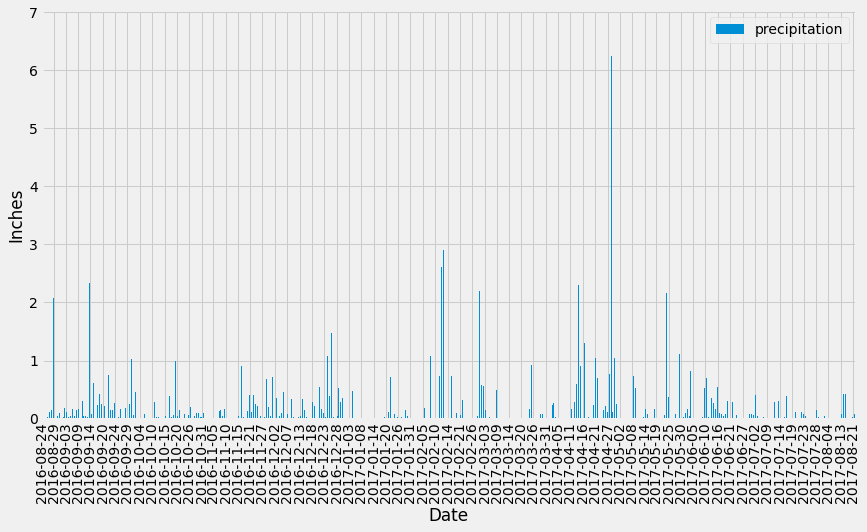

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = dt.datetime.strptime(most_recent_date_str, '%Y-%m-%d')
print(most_recent_date)

# Calculate the date one year from the last date in data set.
start_date = most_recent_date - dt.timedelta(days=+365)
print(start_date)

# Perform a query to retrieve the data and precipitation scores
results = session.query( 
    Measurement.date, 
    Measurement.prcp 
).filter(
    Measurement.date >= start_date
).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

print(type(results))
print(type(results[0]))
print(results[0])
columns = ['date','prcp']
df = pd.DataFrame(columns=columns)
df = df.append(results)
df.set_index('date', inplace=True)
df.index.values

# Sort the dataframe by date
df_sorted = df.sort_values(by="date", ascending=True)
df_sorted.dropna(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df_sorted.rename(columns={'prcp': 'precipitation'}, inplace=True)

ax = df_sorted.plot(kind='bar', grid=True, legend=True, rot=90, figsize=(13,7))

ax.set_xlabel("Date")
ax.set_ylabel("Inches")

ax.xaxis.set_major_locator(mdates.MonthLocator())

plt.show()

In [12]:
print(type(results[0].prcp))

<class 'float'>


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_sorted.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
m_results = session.query(
    Measurement.station
).group_by(
    Measurement.station
).all()

m_df = pd.DataFrame(columns=['station'])
m_df = m_df.append(m_results)
print(f"Total number stations: {len(m_df)}")
m_df

Total number stations: 9


,station
0,USC00511918
1,USC00513117
2,USC00514830
3,USC00516128
4,USC00517948
5,USC00518838
6,USC00519281
7,USC00519397
8,USC00519523


In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
counter = func.count(Measurement.station)
mc_results = session.query(
    Measurement.station,
    counter
).group_by(
    Measurement.station
).order_by(
    counter.desc()
).all()

mc_df = pd.DataFrame(mc_results, columns =['station', 'count'])
mc_df

,station,count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
print(f"lowest temperature: {mc_df.iloc[0]['count']}")
print(f"highest temperature: {mc_df.iloc[len(mc_df)-1]['count']}")
print(f"average temperature: {mc_df['count'].mean()}")

lowest temperature: 2772
highest temperature: 511
average temperature: 2172.222222222222


Text(0, 0.5, 'Frecuency')

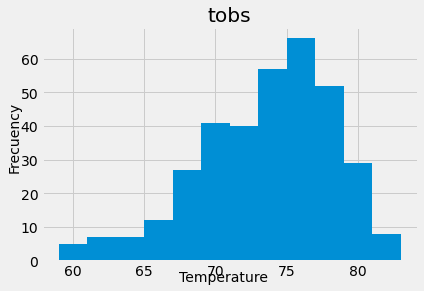

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_results = session.query(
    Measurement.date, 
    Measurement.tobs
).filter(
    Measurement.date >= start_date, 
    Measurement.station == 'USC00519281'
).all()



most_df = pd.DataFrame(most_results, columns =['date', 'tobs'])

fig, axes = plt.subplots(sharex=True, sharey=True)
most_df.hist(ax=axes, bins=12)

fig.text(0.5, 0, 'Temperature', ha='center')
fig.text(0, 0.5, 'Frecuency', va='center', rotation='vertical')


# Close session

In [18]:
# Close Session
session.close()